# Creating a fully connected neural network

In [12]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import Image
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets.
from sklearn.metrics import confusion_matrix
import seaborn as sns
import subprocess

In [31]:
# Selection of a GPU
gpu_num = -1
for i in range(8):
    result = subprocess.run(f"nvidia-smi -i {i}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if "No running processes found" in result.stdout:
        gpu_num = i
        break
        
while 0 > gpu_num or gpu_num > 7:
    !nvidia-smi
    gpu_num = int(input("No Free GPUs Found, manually enter GPU index!"))  
    
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


Network specs for the layers to make easy edits

In [3]:
file_name = "256_No_LD_AI_And_Classes_features_resnet.npz"

data = np.load(f"Features/{file_name}")
features = data['features']
labels = data['labels']

X = features
y = labels

print(X.shape)
print(y.shape)

# Get the number of unique classes
num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

(122923, 2048)
(122923,)
Number of classes: 20


In [4]:
# Network Specs
input_size = X.shape[1]  # image data size
output_size = num_classes
# Training parameters
batch_size = 512
epochs = 50
lrate = 0.01
patience = 16

In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # self.fc1=nn.Linear(input_size, input_size//2)
        # self.fc2=nn.Linear(input_size//2, input_size//4)
        # self.fc3=nn.Linear(input_size//4, input_size//8)
        self.outputLayer=nn.Linear(input_size, output_size)
        self.relu=nn.ReLU()

    def forward(self, x):
        x=x.view(-1, input_size)
        # x=self.fc1(x)
        # x=self.relu(x)
        # x=self.fc2(x)
        # x=self.relu(x)
        # x=self.fc3(x)
        # x=self.relu(x)
        x=self.outputLayer(x)
        return x

In [6]:
# Split into testing and training data
X, X_test, y, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

X_tensor = torch.tensor(X_train, dtype=torch.float32)  # Ensure dtype is appropriate for your data
y_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch Datasets and DataLoaders for training, test, and validation
train_dataset = TensorDataset(X_tensor, y_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

print('Data loaders created successfully.')

Data loaders created successfully.


In [7]:
#instantiate the model, while also defining loss function & optimizer
model = NeuralNet().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lrate)

NeuralNet(
  (outputLayer): Linear(in_features=2048, out_features=20, bias=True)
  (relu): ReLU()
)


Epoch [1/50], Loss: 2.3054
Epoch [2/50], Loss: 1.7082
Epoch [3/50], Loss: 1.5241
Epoch [4/50], Loss: 1.4574
Epoch [5/50], Loss: 1.3940
Epoch [6/50], Loss: 1.3729
Epoch [7/50], Loss: 1.3358
Epoch [8/50], Loss: 1.3184
Epoch [9/50], Loss: 1.3054
Epoch [10/50], Loss: 1.2967
Epoch [11/50], Loss: 1.2870
Epoch [12/50], Loss: 1.2859
Epoch [13/50], Loss: 1.2645
Epoch [14/50], Loss: 1.2863
Epoch [15/50], Loss: 1.2787
Epoch [16/50], Loss: 1.2718
Epoch [17/50], Loss: 1.2551
Epoch [18/50], Loss: 1.2463
Epoch [19/50], Loss: 1.2586
Epoch [20/50], Loss: 1.2417
Epoch [21/50], Loss: 1.2402
Epoch [22/50], Loss: 1.2616
Epoch [23/50], Loss: 1.2523
Epoch [24/50], Loss: 1.2434
Epoch [25/50], Loss: 1.2463
Epoch [26/50], Loss: 1.2551
Epoch [27/50], Loss: 1.2480
Epoch [28/50], Loss: 1.2566
Epoch [29/50], Loss: 1.2332
Epoch [30/50], Loss: 1.2318
Epoch [31/50], Loss: 1.2491
Epoch [32/50], Loss: 1.2360
Epoch [33/50], Loss: 1.2465
Epoch [34/50], Loss: 1.2476
Epoch [35/50], Loss: 1.2429
Epoch [36/50], Loss: 1.2318
E

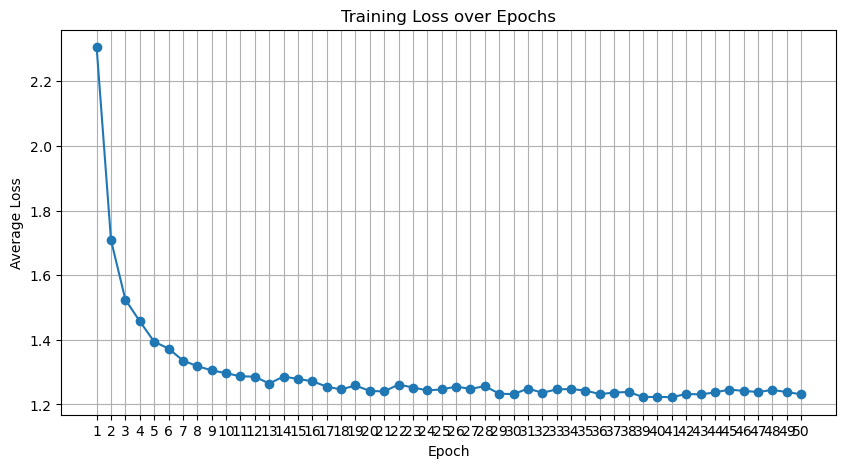

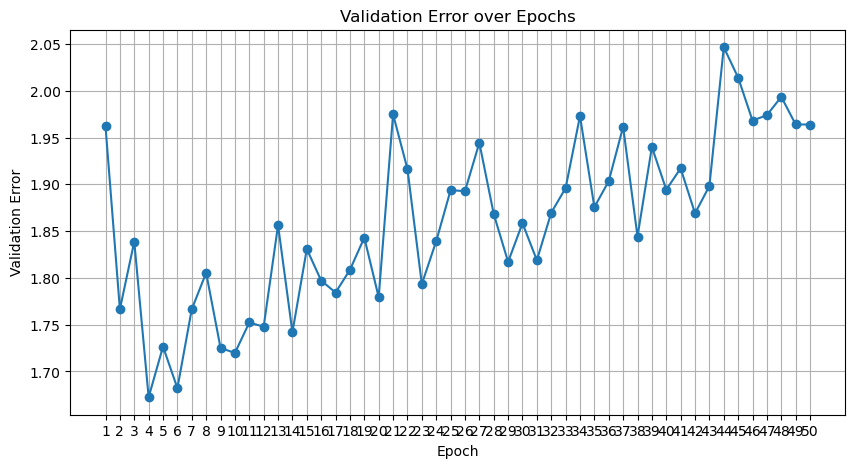

In [8]:
# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=epochs, patience=patience):
    time_start = time()
    model.train()  # Set model to training mode
    epoch_losses = []  # List to store average loss for each epoch
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    final_epoch = -1
    
    for epoch in range(epochs):
        total_loss = 0
        for features, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            outputs = outputs.reshape(outputs.size(0), -1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()           # reset gradient
            loss.backward()                 # automated backwards pass
            optimizer.step()                # take a step

            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  # Store the average loss

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in val_loader:
                labels = labels.type(torch.LongTensor)
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                outputs = outputs.reshape(outputs.size(0), -1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        final_epoch = epoch+2

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs.')
                break

    # Load the best model state
    model.load_state_dict(best_model_state)

    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'Elapsed time {round(time_elapsed, 1)} sec.')

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), epoch_losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

    # Plotting the validation error over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), val_losses, marker='o')
    plt.title('Validation Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Error')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

# Call the training function
train_model(model, train_loader, criterion, optimizer, epochs=epochs, patience=patience)

In [9]:
# # Testing loop
# def test_model(model, test_loader):
#     model.eval()  # Set model to evaluation mode
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             outputs = outputs.reshape(outputs.size(0), -1)
#             _, predicted = torch.max(outputs.data, 1)         # predicted = index of maximum probability
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100 * correct / total
#     print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')

# test_model(model, test_loader)

Test Accuracy of the model on the test dataset: 47.44%


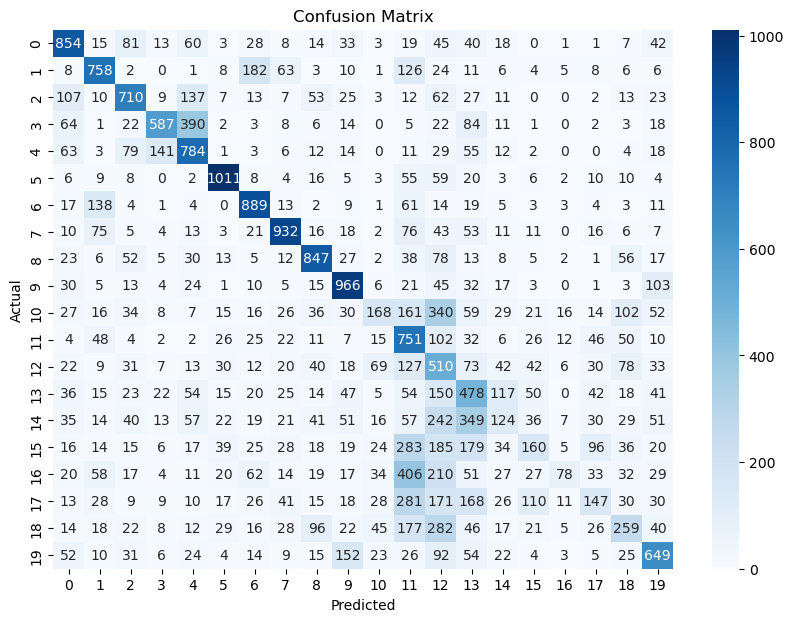

In [10]:

import matplotlib.pyplot as plt

# Testing loop with confusion matrix
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.reshape(outputs.size(0), -1)
            _, predicted = torch.max(outputs.data, 1)  # predicted = index of maximum probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true and predicted labels for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the updated test function
test_model(model, test_loader)


| Device | Dataset                   | Num Images | Image Size | Epochs | Batch Size | Accuracy (%) | Time (sec) |
|:-------|:--------------------------|:-----------|:-----------|:-------|:-----------|:-------------|:-----------|
| GPU    | Small_Just_Classes_Dataset| 1000       | 256x256    | 15     | 512        | 57.00        | 3.4        | 
| GPU    | AI_And_Classes            | 185015     | 256x256    | 15     | 512        | 74.42        | 660.8      |